### Mean plane calculation Stereoplot and Rose diagram
Calculates the mean plane of a given set of planes.

Rotates planes about a given rotation axis

Stereonet plots and Rose diagrams with the module mplstereonet

credits to: http://geologyandpython.com/structural_geology.html

In [1]:
import numpy as np
import pandas as pd # and of course Pandas
import matplotlib.pyplot as plt
import mplstereonet
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
def dir2cart(d):
    """
    Converts a list or array of vector directions in degrees (declination,
    inclination) to an array of the direction in cartesian coordinates (x,y,z)
    Parameters
    d : list or array of [dec,inc] or [dec,inc,intensity]
    Returns
    cart : array of [x,y,z]
    Examples
    >>> pmag.dir2cart([200,40,1])
    array([-0.71984631, -0.26200263,  0.64278761])
    """
    ints = np.ones(len(d)).transpose(
    )  # get an array of ones to plug into dec,inc pairs
    d = np.array(d)
    rad = np.pi/180.
    if len(d.shape) > 1:  # array of vectors
        decs, incs = d[:, 0] * rad, d[:, 1] * rad
        if d.shape[1] == 3:
            ints = d[:, 2]  # take the given lengths
    else:  # single vector
        decs, incs = np.array(float(d[0])) * rad, np.array(float(d[1])) * rad
        if len(d) == 3:
            ints = np.array(d[2])
        else:
            ints = np.array([1.])
    cart = np.array([ints * np.cos(decs) * np.cos(incs), ints *
                     np.sin(decs) * np.cos(incs), ints * np.sin(incs)]).transpose()
    return cart

def cart2dir(cart):
    """
    Converts a direction in cartesian coordinates into declination, inclinations
    Parameters
    cart : input list of [x,y,z] or list of lists [[x1,y1,z1],[x2,y2,z2]...]
    Returns
    direction_array : returns an array of [declination, inclination, intensity]
    Examples
    >>> pmag.cart2dir([0,1,0])
    array([ 90.,   0.,   1.])
    """
    cart = np.array(cart)
    rad = np.pi / 180.  # constant to convert degrees to radians
    if len(cart.shape) > 1:
        Xs, Ys, Zs = cart[:, 0], cart[:, 1], cart[:, 2]
    else:  # single vector
        Xs, Ys, Zs = cart[0], cart[1], cart[2]
    if np.iscomplexobj(Xs):
        Xs = Xs.real
    if np.iscomplexobj(Ys):
        Ys = Ys.real
    if np.iscomplexobj(Zs):
        Zs = Zs.real
    Rs = np.sqrt(Xs**2 + Ys**2 + Zs**2)  # calculate resultant vector length
    # calculate declination taking care of correct quadrants (arctan2) and
    # making modulo 360.
    Decs = (np.arctan2(Ys, Xs) / rad) % 360.
    try:
        # calculate inclination (converting to degrees) #
        Incs = np.arcsin(Zs/Rs) /rad
    except:
        print('trouble in cart2dir')  # most likely division by zero somewhere
        return np.zeros(3)

    return np.array([Decs, Incs, Rs]).transpose()  # return the directions list

def untilt(geo_di, axis_azimuth, rot_angle):
    """
    Rotates vectors about a horizontal rotation axis and (rot_angle: + clockwise, - counterclockwise)
    Parameters:
    geo_di : input list of [dec, inc] or list of lists [[dec1,inc1],[dec2,inc2]...]
    axis_azimuth: azimuth of horizontal rotation axis
    rot_angle: angle of rotation about the horizontal axis
    Returns:
    direction_array : returns an array of rotated vectors[declination, inclination]
    """
    #change geographic coordinates to bedding-strike coordinates (N--> bedding strike, E --> dipdir). returning unit vectors
    geo_cart =dir2cart(geo_di)                                    #returns cartesian coordinates of polar directions [N,E,down]
    strike_coord_cart =np.array([np.sqrt(np.square(geo_cart[:,0])+np.square(geo_cart[:,1]))*np.cos(np.radians(geo_di[:,0]-axis_azimuth)),
                            np.sqrt(np.square(geo_cart[:,0])+np.square(geo_cart[:,1]))*np.sin(np.radians(geo_di[:,0]-axis_azimuth)),
                            geo_cart[:,2]]).transpose()
    #rotate about the axis
    strike_coord_cart_rotated = np.array([strike_coord_cart[:,0],
                            np.cos(np.arctan2(strike_coord_cart[:,2],strike_coord_cart[:,1])+np.radians(rot_angle))*np.sqrt(np.square(strike_coord_cart[:,1])+ np.square(strike_coord_cart[:,2])),
                            np.sin(np.arctan2(strike_coord_cart[:,2],strike_coord_cart[:,1])+np.radians(rot_angle))*np.sqrt(np.square(strike_coord_cart[:,1])+ np.square(strike_coord_cart[:,2]))]).transpose()
    strike_coord_di_rotated = cart2dir(strike_coord_cart_rotated)   #returns polar coord of cartesian coord [dec, inc]
    #return to geographic coordinates [North,East,Down]
    geo_di_rotated = strike_coord_di_rotated                                                                                                      
    geo_di_rotated[:,0] = geo_di_rotated[:,0]+axis_azimuth
    #np.round(geo_di_rotated[:,:2])
    return geo_di_rotated[:,:2]

# polar mean function
def polar_mean(x):
    cos_a = 0
    sin_a = 0
    for a in x:                         #loop to sum the sinus and cosinus of all directional data
        cos_a += np.cos(np.radians(a))
        sin_a += np.sin(np.radians(a))
    mean = np.degrees(np.arctan2(sin_a,cos_a))    # calculates the mean from arctang of the the sum of sinus and cosinus
    return(mean)

# Standard deviation function
def standard_deviation(x,x_mean):
    sum_squared_diferences = 0
    for a in x:               #loop to calculate the sum of the squared difference of the individual directions to the mean
        squared_diferences = (2*np.degrees(np.arcsin(np.sqrt(
            (np.cos(np.radians(a))-np.cos(np.radians(x_mean)))**2+
            (np.sin(np.radians(a))-np.sin(np.radians(x_mean)))**2)
            /2)))**2
        sum_squared_diferences += squared_diferences    #summ of squared differences
    std_dev = np.sqrt(sum_squared_diferences/len(x))    # standard deviation = squared root of summatory divided by number of data
    return(std_dev)

#### Input

In [3]:
from tkinter import *
from tkinter import filedialog
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

filename = filedialog.askopenfilename(filetypes = (('excel XLS', '*.xls'),('excel XLSX', '*.xlsx'))) 
print(filename)
data = pd.read_excel(filename)
data.head()

C:/Users/Miguel Garces.ID43278/OneDrive - Universitat de Barcelona/Documentos - UB_Estratigrafia_PDI/General/practiques/05_paleocorrents_I/exercici_2/Dades exercici2.xlsx


,bed_strike,bed_dip,x-strike,x-dip
0,320,65,294,53
1,320,65,287,54
2,320,65,288,46
3,320,65,280,77
4,320,65,285,53


In [4]:
# Select data from dataframe
option ={}
for n in range(len(data.columns)):
    key_value_pair ={n+1:data.columns[n]}
    option.update(key_value_pair)

column_strike = int(input(color.BOLD + color.RED + 'PLANE STRIKE. Choose column ' + str(option)+':'))
print(color.BOLD + str.upper(option[column_strike]+ '  selected') + color.END)
column_dip = int(input(color.BOLD + color.RED + 'PLANE DIP. Choose column  ' + str(option)+':'))
print(color.BOLD + str.upper(option[column_dip]+ '  selected') + color.END)


#data.rename(columns={option[column_strike]: 'Strike', option[column_dip]: 'Dip'}, inplace=True)

PLANE STRIKE. Choose column {1: 'bed_strike', 2: 'bed_dip', 3: 'x-strike', 4: 'x-dip'}:3
X-STRIKE  SELECTED
PLANE DIP. Choose column  {1: 'bed_strike', 2: 'bed_dip', 3: 'x-strike', 4: 'x-dip'}:4
X-DIP  SELECTED


In [5]:
'''#Set bedding orientation
bedding = dict(strike = 320, dip = 30)
'''

'#Set bedding orientation\nbedding = dict(strike = 320, dip = 30)\n'

In [6]:
# Set bedding orientation
bedding = {}
bedding['strike'] = float(input('Bedding strike:'))
bedding['dip'] = float(input('Bedding dip:'))

Bedding strike:320
Bedding dip:65


#### Method to calculate mean plane:
1. Convert planes to poles
2. Convert poles to XYZ coordinates with function dir2cart().
3. Calculate mean pole by sum of all X, Y, and Z components.
4. Convert mean pole from XYZ to polar coordinates with function cart2dir().
5. Convert mean pole to mean plane


### In situ

In [7]:
#Calculate planes poles
ones = np.full((len(data), 1), int(1))
planes_poles = np.append(np.array([data[option[column_strike]]+270]),
                         90 - np.array([data[option[column_dip]]]), axis =0).T

# Cartesian coordinates of bedding poles
planes_poles = np.append(planes_poles, ones, axis =1)  #Calculate the mean bedding pole
cartesian_coord = dir2cart(planes_poles)
data['poleX'],data['poleY'],data['poleZ'] = cartesian_coord[:,0],cartesian_coord[:,1],cartesian_coord[:,2]

# Calculate the mean pole
mean_pole_cart = np.array([data['poleX'].sum(),data['poleY'].sum(),data['poleZ'].sum()])
mean_pole_di = cart2dir(mean_pole_cart).round(1)

# Calculate the mean plane
mean_plane = np.array([mean_pole_di[0]+90,90-mean_pole_di[1]]).round(1)
if mean_pole_di[0] > 270:
    mean_plane = np.array([mean_pole_di[0]-270,90-mean_pole_di[1]]).round(1)
else:
    pass

#Calculate standard deviation
mean_pole_cart/=np.linalg.norm(mean_pole_cart) #mean pole unit vector
sumatori = 0
for n in range(len(data)):
    m = (2*np.arcsin(np.sqrt((data['poleX'][n]-mean_pole_cart[0])**2+
                       (data['poleY'][n]-mean_pole_cart[1])**2+
                       (data['poleZ'][n]-mean_pole_cart[2])**2)/2))**2
    sumatori += m
stdev = np.degrees(np.sqrt(sumatori/(len(data)))).round(1)

print(color.RED + color.BOLD + 'GEOGRAPHIC COORDINATES'.format()+ color.END)
print('The mean pole (azimuth/dip) is '+color.BOLD +'{0}/{1}'.format(mean_pole_di[0],mean_pole_di[1])+ color.END)
print('The mean plane orientation (strike/dip) is '+color.BOLD +'{0}/{1}'.format(mean_plane[0],mean_plane[1])+ color.END)
print('The standard deviation (in degrees) is '+color.BOLD +'{0}'.format(stdev)+ color.END)

GEOGRAPHIC COORDINATES
The mean pole (azimuth/dip) is 185.6/33.2
The mean plane orientation (strike/dip) is 275.6/56.8
The standard deviation (in degrees) is 14.5


### Bedding corrected

In [8]:
#Calculate poles of planes
ones = np.full((len(data), 1), int(1))
planes_poles = np.append(np.array([data[option[column_strike]]+270]), 90 - np.array([data[option[column_dip]]]), axis =0).T
planes_poles_corrected = untilt(planes_poles,bedding['strike'],-bedding['dip'])         #poles corrected for bedding tilt
data['Strike_corrected'] = pd.DataFrame(planes_poles_corrected[:,0]+90)                 #get strike from pole orientation
for n in range(len(data)):
    if data.loc[n,'Strike_corrected']>360:
        data.loc[n,'Strike_corrected'] = data.loc[n,'Strike_corrected'] - 360
    else:
        pass
        
data['Dip_corrected'] = pd.DataFrame(90-planes_poles_corrected[:,1])                    #get dip from pole orientation

# Cartesian coordinates of bedding poles
planes_poles_corrected = np.append(planes_poles_corrected, ones, axis =1)  #Calculate the mean bedding pole
cartesian_coord_corrected = dir2cart(planes_poles_corrected)
data['poleX_corr'],data['poleY_corr'],data['poleZ_corr'] = cartesian_coord_corrected[:,0],cartesian_coord_corrected[:,1],cartesian_coord_corrected[:,2]


# Calculate the mean pole
mean_pole_cart_corr = np.array([data['poleX_corr'].sum(),data['poleY_corr'].sum(),data['poleZ_corr'].sum()])
mean_pole_di_corr = cart2dir(mean_pole_cart_corr).round(1)

# Calculate the mean plane
mean_plane_corr = np.array([mean_pole_di_corr[0]+90,90-mean_pole_di_corr[1]]).round(1)
if mean_pole_di_corr[0] > 270:
    mean_plane_corr = np.array([mean_pole_di_corr[0]-270,90-mean_pole_di_corr[1]]).round(1)
else:
    pass

#Calculate standard deviation
mean_pole_cart_corr/=np.linalg.norm(mean_pole_cart_corr) #mean pole unit vector
sumatori = 0
for n in range(len(data)):
    m = (2*np.arcsin(np.sqrt((data['poleX_corr'][n]-mean_pole_cart_corr[0])**2+
                       (data['poleY_corr'][n]-mean_pole_cart_corr[1])**2+
                       (data['poleZ_corr'][n]-mean_pole_cart_corr[2])**2)/2))**2
    sumatori += m
stdev_corr = np.degrees(np.sqrt(sumatori/(len(data)))).round(1)

print(color.RED + color.BOLD +'BEDDING CORRECTED COORDINATES'.format()+ color.END)
print('The mean pole (azimuth/dip) is '+color.BOLD +'{0} / {1}'.format(mean_pole_di_corr[0],mean_pole_di_corr[1])+ color.END)
print('The mean plane orientation (strike/dip) is '+color.BOLD +'{0} / {1}'.format(mean_plane_corr[0],mean_plane_corr[1])+ color.END)
print('The standard deviation (in degrees) is '+color.BOLD +'{0}'.format(stdev_corr)+ color.END)

BEDDING CORRECTED COORDINATES
The mean pole (azimuth/dip) is 117.4 / 50.7
The mean plane orientation (strike/dip) is 207.4 / 39.3
The standard deviation (in degrees) is 14.5


C:\Users\Miguel Garces.ID43278\Anaconda3\lib\site-packages\mplstereonet\stereonet_transforms.py:139: RuntimeWarning: invalid value encountered in arcsin
  return 2.0 * np.arcsin(0.5 * p)


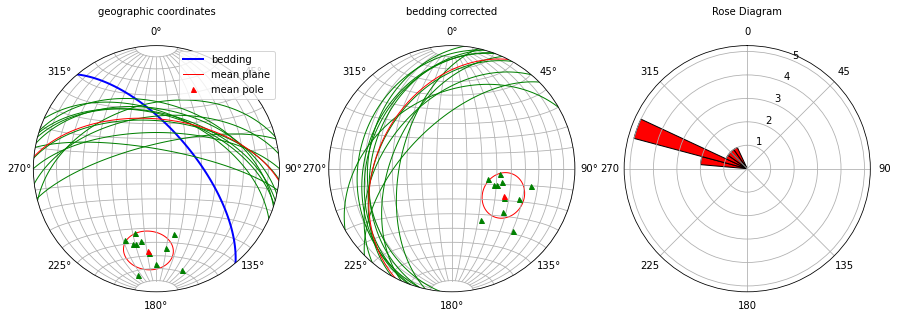

In [9]:
#Plot data on stereonet

fig = plt.figure(figsize=(15, 5))
#first stereoplot
strike = list(data[option[column_strike]])
dip = list(data[option[column_dip]])
mean_strike, mean_dip = mean_plane[0], mean_plane[1]
mean_pole_bearing, mean_pole_plunge = mean_pole_di[0],mean_pole_di[1]
girdle_strike, girdle_dip = mplstereonet.fit_girdle(strike, dip)

ax = fig.add_subplot(131, projection='stereonet')
ax.plane(bedding['strike'],bedding['dip'], 'b', linewidth=2, label='bedding')
ax.plane(strike, dip, 'g-', linewidth=1)
ax.plane(mean_strike,mean_dip,'r-',linewidth=1, label = 'mean plane')
ax.cone(mean_pole_plunge,mean_pole_bearing,stdev,color='red', facecolor='none') #plunge, bearing, angle(radius) of semicone
ax.pole(strike, dip, 'g^', markersize=5)
ax.pole(mean_strike,mean_dip, 'r^', markersize=5, label='mean pole')
#ax.pole(girdle_strike, girdle_dip, c='r', label='Beta axis')
#ax.rake(strike, dip, -25)
#ax.line(30,10)
ax.grid()
ax.legend()
ax.set_title('geographic coordinates', y=1.10, fontsize=10)

#second stereoplot
strike_corr = list(data['Strike_corrected'])
dip_corr = list(data['Dip_corrected'])
mean_strike_corr, mean_dip_corr = mean_plane_corr[0], mean_plane_corr[1]
mean_pole_bearing_corr, mean_pole_plunge_corr = mean_pole_di_corr[0],mean_pole_di_corr[1]
girdle_strike_corr, girdle_dip_corr = mplstereonet.fit_girdle(strike_corr, dip_corr)
                
ax = fig.add_subplot(132, projection='stereonet')
ax.plane(strike_corr, dip_corr, 'g-', linewidth=1)
ax.plane(mean_strike_corr,mean_dip_corr,'r-',linewidth=1)
ax.cone(mean_pole_plunge_corr,mean_pole_bearing_corr,stdev,color='red', facecolor='none') #plunge, bearing, angle(radius) of semicone
ax.pole(strike_corr, dip_corr, 'g^', markersize=5)
ax.pole(mean_strike_corr,mean_dip_corr, 'r^', markersize=5, label='mean pole')
#ax.pole(girdle_strike_corr, girdle_dip_corr, c='r', label='Beta axis')
#ax.rake(strike, dip, -25)
#ax.line(30,10)
ax.grid()
#ax.legend()
ax.set_title('bedding corrected', y=1.10, fontsize=10)


#Plotting Rose diagram
dipdir = np.array(data['Strike_corrected']+90) # Get dip direction from the strike of planes (right hand rule applied)
bin_edges = np.arange(-5, 366, 10)   # Set number of bins = 10
number_of_strikes, bin_edges = np.histogram(dipdir, bin_edges)  # Calculate the number of directions (strikes) every 10° using numpy.histogram.
number_of_strikes[0] += number_of_strikes[-1]  # Sum the last value with the first value
number_of_strikes = number_of_strikes[:-1]

ax = fig.add_subplot(133, projection='polar')
ax.bar(np.deg2rad(np.arange(0, 360, 10)), number_of_strikes, 
       width=np.deg2rad(10), bottom=0.0, color='red', edgecolor='k')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 10))
ax.set_thetagrids(np.arange(0, 360, 45), labels=np.arange(0, 360, 45))
#ax.set_rgrids(np.arange(1, number_of_strikes.max() + 1, 2), angle=0, weight= 'black')
ax.set_title('Rose Diagram', y=1.10, fontsize=10)

#fig.tight_layout()
fig.savefig('my_stereonet.pdf')
plt.show()

In [10]:
#Calculate mean direction and standard error
dip_direction = np.array(data['Strike_corrected']+90)
mean_dip_direction = polar_mean(np.array(dip_direction))
if mean_dip_direction <0:
    mean_dip_direction = mean_dip_direction +360
elif mean_dip_direction >360:
    mean_dip_direction = mean_dip_direction - 360
else:
    pass
paleocurrent_std_dev = standard_deviation(dip_direction,mean_dip_direction)

statistics = [[len(dip_direction), int(mean_dip_direction), paleocurrent_std_dev ]]

df_stats = pd.DataFrame(statistics, index = ['dip_directions'], columns =['N', 'mean', 'standard dev'])
df_stats.round(1)

,N,mean,standard dev
dip_directions,11,296,15.5
